# Heart Diagnosis Using Electrocardiogram Measurements

## HW-Shapes ECE 594N W23
### Authors: [Nima Namazi](mailto:mnamazi@ece.ucsb.edu) & [Monsij Biswal](mbiswal@ece.ucsb.edu)

- Welcome to the visualization notebook !



**Introduction**

The dataset used for this project is about 12-lead electrocardiogram signals created by Chapman University and Shaoxing People's Hospital [1]. Below are some key aspects of the dataset:

- 12-lead ECG Database consists of arrhythmia research covering more than 10,646 patients. 
- Sampled at 500 Hz for 10 seconds
- Labels include the kinds rhythm and beat abnormalities observed

[1] Zheng, Jianwei, Jianming Zhang, Sidy Danioko, Hai Yao, Hangyuan Guo, and Cyril Rakovski. “A 12-Lead Electrocardiogram Database for Arrhythmia Research Covering More than 10,000 Patients.” Scientific Data 7, no. 1 (February 12, 2020): 48. https://doi.org/10.1038/s41597-020-0386-x.


### Biomedical question

Can the covariance data, which lies on the SPD manifold, help cluster different patient diagnoses?



In [1]:
# Loading requirements
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
from data_util import *

base_path = './ECGDataDenoisedMat/'



# sample dataset is already included, full dataset can be found at the link below : 
# https://www.kaggle.com/datasets/erarayamorenzomuten/chapmanshaoxing-12lead-ecg-database/download?datasetVersionNumber=1

INFO: Using numpy backend


In [7]:
patient_id = get_random_patient_id()
sample_data = get_single_data(patient_id=patient_id)
print('Shape of ECG data: ', sample_data.shape)    # number of leads = 12 (rows), samples = 5000 (columns)
print('Some values: ', sample_data[7, 50:55])      # Unit microV

Shape of ECG data:  (12, 5000)
Some values:  [6.6202 5.8227 4.992  4.1809 3.4344]


### Time samples of ECG data

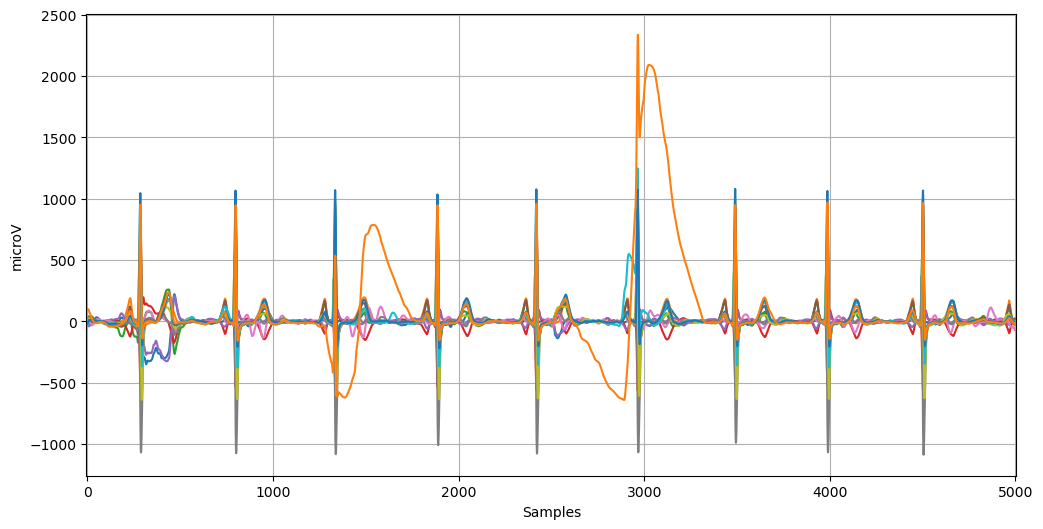

In [8]:
plot_ecg(patient_id=patient_id, lead=-1)

## Visualizing the correlation matrix 

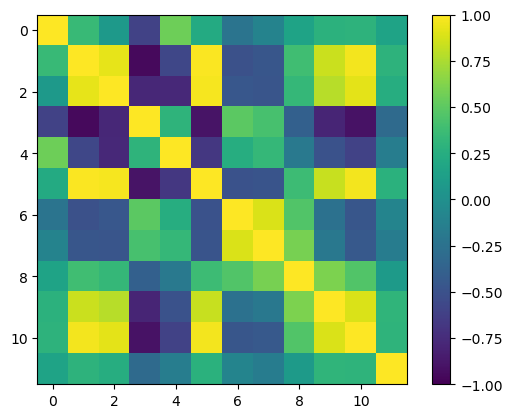

In [9]:
cor_mat = compute_corr_mat(patient_id=patient_id, plot_corr=True)

## Correlation matrices lies on SPD Manifold !

In [10]:
file_paths = get_all_file_paths()
num_files = len(file_paths)
on_manifold = 0
for file in file_paths:
    cor_mat = compute_corr_mat(file, plot_corr=False)
    if check_on_manifold(cor_mat):
        on_manifold += 1
print("Percentage of correlation matrices on SPD Manifold: {:.2f}".format((on_manifold/num_files)*100))


Percentage of correlation matrices on SPD Manifold: 99.84


## Dataset overview

| Acronym Name | Full Name                                    | Number of instances |
|--------------|----------------------------------------------|---------------------|
| SB           | Sinus Bradycardia                            | 3889                |
| SR           | Sinus Rhythm                                 | 1825                |
| AFIB         | Atrial Fibrillation                          | 1780                |
| ST           | Sinus Tachycardia                            | 1564                |
| AF           | Atrial Flutter                               | 445                 |
| SI           | Sinus Irregularity                           |  ~                  |
| SVT          | Supraventricular Tachycardia                 | 585                 |
| AT           | Atrial Tachycardia                           | 120                 |
| AVNRT        | Atrioventricular  Node Reentrant Tachycardia |  ~                  |
| AVRT         | Atrioventricular Reentrant Tachycardia       | 8                   |
| SAAWR        | Sinus Atrium to Atrial Wandering Rhythm      | ~                   |

## Average correlation heatmap and standard deviations per class

- Sinus Rhythm and Sinus Bradycardia have fairly similar mean and standard deviation heatmaps (subtle differences for example bottom left of the mean heatmap)

- Atrial Fibrillation and Atrial Tachycardia have unique mean and standard deviation heatmaps when compared with the rest.

In [ ]:
chosen_classes = ["AFIB", "SR", "SB", "ST"]
chosen_classes_names = ["Atrial Fibrillation", "Sinus Rhythm", "Sinus Bradycardia", "Sinus Tachycardia"]

file_paths = get_all_file_paths()

fig = plt.gcf()
fig.set_size_inches(16, 16)
init_labels()


pos = 1
for k in range(4):
    average_corr_matrix = np.zeros(np.shape(cor_mat))
    std_corr_matrix = np.zeros(np.shape(cor_mat))
    num_patients_in_class = 0
    for file in file_paths:
        if get_rhythm_acr(file) == chosen_classes[k]:
            correl_mat = compute_corr_mat(file, plot_corr=False)
            if check_on_manifold(correl_mat):
                num_patients_in_class += 1
                average_corr_matrix += correl_mat
    average_corr_matrix = average_corr_matrix/num_patients_in_class
    plt.subplot(4,2,pos)
    plt.imshow(average_corr_matrix, cmap='plasma', vmin=-1, vmax=1)
    plt.title(chosen_classes_names[k] + " Mean")
    plt.colorbar()
    for file in file_paths:
        if get_rhythm_acr(file) == chosen_classes[k]:
            correl_mat = compute_corr_mat(file, plot_corr=False)
            if check_on_manifold(correl_mat):
                std_corr_matrix += np.square((correl_mat - average_corr_matrix))
    plt.subplot(4,2,pos+1)
    plt.imshow(np.sqrt(std_corr_matrix/num_patients_in_class), cmap='viridis', vmax = 0.5, vmin = 0)
    plt.title(chosen_classes_names[k] + " STD")
    plt.colorbar()
    pos +=2

plt.show() 

            
            

In [18]:
#Loaded needed ML packages and data
from geomstats.geometry.spd_matrices import SPDMatrices
from geomstats.learning.preprocessing import ToTangentSpace
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

spd_manifold = SPDMatrices(n=12)

mat, all_ids, targets = load_Chapman_ECG()
mat = np.asarray(mat)
print("Shape of loaded ECG Data: ", mat.shape)

#Splitting dataset for generating train and test sets

X = mat
y = targets
X_train, X_test, y_train, y_test = train_test_split(X, y)

Loading denoised dataset of Chapman Shaoxing 12-lead ECG Data...


100%|██████████| 10606/10606 [00:58<00:00, 181.79it/s]

Shape of loaded ECG Data:  (9058, 12, 12)


## Classification on the tangent space

### 1. Logistic Regression

In [ ]:
#Logistic regression with tangent space method
from sklearn.model_selection import GridSearchCV

lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=spd_manifold.metric)),
        ("standardscaler", StandardScaler()),
        ("classifier", LogisticRegression(max_iter=10000)),
    ]
)

grid_values = {'classifier__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
              'classifier__solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}

X = mat
y = targets
X_train, X_test, y_train, y_test = train_test_split(X, y)

search = GridSearchCV(lr_pipeline, grid_values, cv=3)

search.fit(X_train, y_train)

print(search.best_params_)
print("Accuracy:{:.2f} ".format(search.score(X_test, y_test)))

In [ ]:
#Confusion matrix for logistic regression with tangent space method

from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = search.predict(X_test)

get_confusion_matrix(y_test, y_pred, target_class_list=['SR','SB', 'ST', 'AFIB'])

### 2. Support Vector Machine

In [ ]:
#SVM classifier with tangent space method
from sklearn.svm import SVC

lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=spd_manifold.metric)),
        ("standardscaler", StandardScaler()),
        ("classifier", SVC()),
    ]
)

grid_values = {'classifier__C': [0.001, 0.01, 0.1, 1, 10],
              'classifier__kernel': ['linear','poly', 'rbf', 'sigmoid'],
              'classifier__degree': [2, 3, 4]}

X = mat
y = targets
X_train, X_test, y_train, y_test = train_test_split(X, y)

search = GridSearchCV(lr_pipeline, grid_values, cv=3)

search.fit(X_train, y_train)

print(search.best_params_)
print("Accuracy:{:.2f} ".format(search.score(X_test, y_test)))

In [ ]:
#Confusion matrix for SVM with tangent space method

from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = search.predict(X_test)

get_confusion_matrix(y_test, y_pred, target_class_list=['SR','SB', 'ST', 'AFIB'])

### 3. Random Forest

In [ ]:
#Random forest classifier with tangent space method
from sklearn.ensemble import RandomForestClassifier

lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=spd_manifold.metric)),
        ("standardscaler", StandardScaler()),
        ("classifier", RandomForestClassifier()),
    ]
)

grid_values = {'classifier__n_estimators': [10, 100, 1000],
              'classifier__criterion': ['gini', 'entropy', 'log_loss']}

X = mat
y = targets
X_train, X_test, y_train, y_test = train_test_split(X, y)

search = GridSearchCV(lr_pipeline, grid_values, cv=3)

search.fit(X_train, y_train)

print(search.best_params_)
print("Accuracy:{:.2f} ".format(search.score(X_test, y_test)))

In [ ]:
#Confusion matrix for random forest with tangent space method

from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = search.predict(X_test)

get_confusion_matrix(y_test, y_pred, target_class_list=['SR','SB', 'ST', 'AFIB'])

### 4. Adaboost Classifier

In [ ]:
#Adaboost classifier with tangent space method
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV


lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=spd_manifold.metric)),
        ("standardscaler", StandardScaler()),
        ("classifier", AdaBoostClassifier(n_estimators=200, learning_rate=0.5)),
    ]
)

grid_values = {'classifier__n_estimators': [25, 50, 100, 1000],
              'classifier__learning_rate': [1e-6, 1e-4, 1e-2, 1, 5, 10]}




X = mat
y = targets
X_train, X_test, y_train, y_test = train_test_split(X, y)

search = GridSearchCV(lr_pipeline, grid_values, cv=3)

search.fit(X_train, y_train)

print(search.best_params_)
print("Accuracy:{:.2f} ".format(search.score(X_test, y_test)))

In [ ]:
#Confusion matrix for Adaboost with tangent space method

from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = search.predict(X_test)

get_confusion_matrix(y_test, y_pred, target_class_list=['SR','SB', 'ST', 'AFIB'])

### 5. Multi-layer perceptron

In [ ]:
#MLP classifier with tangent space method

from sklearn.neural_network import MLPClassifier

lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=spd_manifold.metric)),
        ("standardscaler", StandardScaler()),
        ("classifier", MLPClassifier(hidden_layer_sizes=(30,30,30,30),max_iter=10000)),
    ]
)


#test
grid_values = {'classifier__alpha': [0.002,0.02,0.2,2,20,200,2000],
              'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
              'classifier__hidden_layer_sizes': [(30,),(30,30,), (30,30,30,)]}


X = mat
y = targets
X_train, X_test, y_train, y_test = train_test_split(X, y)

search = GridSearchCV(lr_pipeline, grid_values, cv=3)

search.fit(X_train, y_train)

print(search.best_params_)
print("Accuracy:{:.2f} ".format(search.score(X_test, y_test)))

In [ ]:
#Confusion matrix for MLP with tangent space method

from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = search.predict(X_test)

get_confusion_matrix(y_test, y_pred, target_class_list=['SR','SB', 'ST', 'AFIB'])

### 6. K-Nearest Neighbors (k-NN)

In [14]:
#KNN classifier with tangent space method
from sklearn.neighbors import KNeighborsClassifier

lr_pipeline = Pipeline(
    steps=[
        ("trick_tangent_space", ToTangentSpace(geometry=spd_manifold.metric)),
        ("standardscaler", StandardScaler()),
        ("classifier", KNeighborsClassifier(algorithm='brute')),
    ]
)

grid_values = {'classifier__n_neighbors': [5, 10, 20],
              'classifier__weights': ['uniform', 'distance']}

search = GridSearchCV(lr_pipeline, grid_values, cv=3)


X = mat
y = targets
X_train, X_test, y_train, y_test = train_test_split(X, y)
search.fit(X_train, y_train)

print(search.best_params_)
print("Accuracy:{:.2f} ".format(search.score(X_test, y_test)))

/home/mbiswal/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/mbiswal/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be acce

{'classifier__n_neighbors': 20, 'classifier__weights': 'uniform'}
Accuracy:0.46 


/home/mbiswal/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [15]:
#Confusion matrix for KNN with tangent space method

from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = search.predict(X_test)

get_confusion_matrix(y_test, y_pred, target_class_list=['SR','SB', 'ST', 'AFIB'])

/home/mbiswal/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,pred:SR,pred:SB,pred:ST,pred:AFIB
true:SR,0.083,0.781,0.033,0.102
true:SB,0.076,0.788,0.025,0.110
true:ST,0.074,0.637,0.057,0.232
true:AFIB,0.039,0.432,0.048,0.480


## Classification on the SPD manifold

### Minimum Distance to Mean

In [33]:
#Minimum Distance to Mean (MDM) classification

from geomstats.learning.mdm import RiemannianMinimumDistanceToMean
from geomstats.geometry.spd_matrices import *


#spd_manifold = SPDMatrices(n=12)
riemannian_metrics = [SPDLogEuclideanMetric(n=12),
                      SPDEuclideanMetric(n=12),
                      SPDBuresWassersteinMetric(n=12),
                      SPDAffineMetric(n=12)]


for metric in riemannian_metrics:
    mdm = RiemannianMinimumDistanceToMean(
        riemannian_metric=metric)
    mdm.fit(X_train, np.array(y_train))
    print(str(metric).split(' ')[0][1:])
    print("Score: {:.2f}\n".format(mdm.score(X_test, y_test)))
    
#print(spd_manifold.belongs(mdm.mean_estimates_))


geomstats.geometry.spd_matrices.SPDLogEuclideanMetric
Score: 0.42

geomstats.geometry.spd_matrices.SPDEuclideanMetric
Score: 0.37

geomstats.geometry.spd_matrices.SPDBuresWassersteinMetric
Score: 0.39

geomstats.geometry.spd_matrices.SPDAffineMetric
Score: 0.39



In [ ]:
#Riemannian K-means
from geomstats.learning.kmeans import RiemannianKMeans

kmeans = RiemannianKMeans(spd_manifold.metric, 4, tol=1e-3, init_step_size=1.0)

X_train, X_test, y_train, y_test = train_test_split(X, y)

centroids = kmeans.fit(X_train)
spd_manifold.belongs(centroids)

predicted_labels_training = kmeans.predict(X_train)
predicted_labels_training

centroids = kmeans.fit(X_train)
spd_manifold.belongs(centroids)

predicted_labels = kmeans.predict(X_test)
predicted_labels